### DNN 게임 예제

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [22]:
response = 6
batch_size = 50

In [2]:
def print_board(board):
    symbols = ['O',' ','X']
    board_plus1 = [int(x) + 1 for x in board]
    print(' ' + symbols[board_plus1[0]] + ' | ' + symbols[board_plus1[1]]
          + ' | ' + symbols[board_plus1[2]])
    print('___________')
    print(' ' + symbols[board_plus1[3]] + ' | ' + symbols[board_plus1[4]]
          + ' | ' + symbols[board_plus1[5]])
    print('___________')
    print(' ' + symbols[board_plus1[6]] + ' | ' + symbols[board_plus1[7]]
          + ' | ' + symbols[board_plus1[8]])

In [3]:
def get_symmetry(board, response, transformation):
    if transformation == 'rotate180':
        new_response = 8 - response
        return(board[::-1], new_response)
   
    elif transformation == 'rotate90':
        new_response = [6, 3, 0, 7, 4, 1, 8, 5, 2].index(response)
        tuple_board = list(zip(*[board[6:9], board[3:6], board[0:3]]))
        return([value for item in tuple_board for value in item],
               new_response)
   
    elif transformation == 'rotate270':
        new_response = [2, 5, 8, 1, 4, 7, 0, 3, 6].index(response)
        tuple_board = list(zip(*[board[0:3], board[3:6], board[6:9]]))[::-1]
        return([value for item in tuple_board for value in item],
               new_response)
   
    elif transformation == 'flip_v': # 0 1 2 , 3 4 5 , 6 7 8
        new_response = [6, 7, 8, 3, 4, 5, 0, 1, 2].index(response)
        return(board[6:9] +  board[3:6] + board[0:3], new_response)
   
    elif transformation == 'flip_h': 
        new_response = [2, 1, 0, 5, 4, 3, 8, 7, 6].index(response)
        new_board = board[::-1]
        return(new_board[6:9] +  new_board[3:6] + new_board[0:3],
               new_response)
    else:
        raise ValueError('해당하는 경우가 없음')


In [4]:
def get_moves_from_csv(csv_file):
    moves = []
    with open(csv_file, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            moves.append(([int(x) for x in row[0:9]],int(row[9])))
    return(moves)

def get_rand_move(moves, n=1, rand_transforms=2):
    (board, response) = random.choice(moves)
    possible_transforms = ['rotate90', 'rotate180', 'rotate270',
                           'flip_v', 'flip_h']
    for i in range(rand_transforms):
        random_transform = random.choice(possible_transforms)
        (board, response) = get_symmetry(board, response, random_transform)
    return(board, response)

In [5]:
moves = get_moves_from_csv('./data/tictactoe_moves.csv')

In [7]:
train_length = 500
train_set = []
print(train_set)

[]


In [9]:
for t in range(train_length):
    train_set.append(get_rand_move(moves))
print(len(train_set))
#print(train_set)

1000


In [12]:
test_board = [-1,0,0,1,-1,-1,0,0,1]
train_set = [x for x in train_set if x[0] != test_board]
#print(train_set)

In [13]:
def init_weights(shape):
    return(tf.Variable(tf.random_normal(shape)))


def model(X, A1, A2, bias1, bias2):
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(X, A1), bias1))
    layer2 = tf.add(tf.matmul(layer1, A2), bias2)
    return(layer2)

In [15]:
X = tf.placeholder(dtype =tf.float32, shape=[None,9])
Y = tf.placeholder(dtype=tf.int32, shape=[None])

A1 = init_weights([9,81])
bias1 = init_weights([81])
A2 = init_weights([81,9])
bias2 = init_weights([9])

model_output = model(X, A1, A2, bias1, bias2)

In [16]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=model_output, labels=Y))

In [18]:
train_step = tf.train.GradientDescentOptimizer(0.025).minimize(loss)

In [19]:
prediction =  tf.argmax(model_output,1)

In [24]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

loss_vec = []
for i in range(10000):
    rand_indices = np.random.choice(range(len(train_set)), batch_size, replace=False)
    batch_data =[train_set[i] for i in rand_indices]
    x_input = [x[0] for x in batch_data]
    y_target = np.array([y[1] for y in batch_data])
    sess.run(train_step, feed_dict = {X: x_input, Y:y_target})
    temp_loss = sess.run(loss, feed_dict = {X:x_input, Y: y_target})
    loss_vec.append(temp_loss)
    if i%500==0:
        print('iteration ' + str(i) + 'Loss:' + str(temp_loss))

iteration 0Loss:9.5715
iteration 500Loss:1.9686471
iteration 1000Loss:1.542092
iteration 1500Loss:1.3021549
iteration 2000Loss:1.4759915
iteration 2500Loss:1.1099411
iteration 3000Loss:1.2100408
iteration 3500Loss:1.4222662
iteration 4000Loss:1.0541872
iteration 4500Loss:0.9218242
iteration 5000Loss:1.1086181
iteration 5500Loss:1.0657312
iteration 6000Loss:1.0219214
iteration 6500Loss:0.9221954
iteration 7000Loss:0.8541118
iteration 7500Loss:0.8989351
iteration 8000Loss:0.9460545
iteration 8500Loss:0.72636384
iteration 9000Loss:0.8455609
iteration 9500Loss:0.7119677


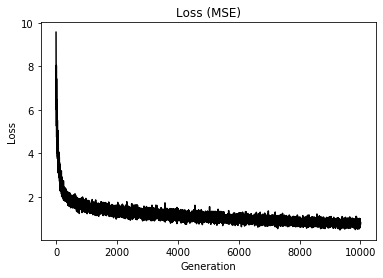

In [25]:
plt.plot(loss_vec, 'k-', label ='Loss')
plt.title('Loss (MSE)')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [26]:
test_boards = [test_board]
feed_dict = {X: test_boards}
logits = sess.run(model_output, feed_dict = feed_dict)
predictions = sess.run(prediction, feed_dict = feed_dict)
print(predictions)

[6]


In [31]:
def check(board):
    wins = [[0,1,2], [3,4,5], [6,7,8], [0,3,6], [1,4,7], [2,5,8],
            [0,4,8], [2,4,6]]
    
    for i in range(len(wins)):
        if board[wins[i][0]]==board[wins[i][1]]==board[wins[i][2]]==1.:
            return 1
        elif board[wins[i][0]]==board[wins[i][1]]==board[wins[i][2]]==-1.:
            return -1
    
    return 0

In [34]:
game_tracker = [0.,0.,0.,0.,0.,0.,0.,0.,0.]
win_logical = False
num_moves =0


In [35]:
while not win_logical:
    player_index = input('이동하고 싶은 인덱스를 입력하시오 (0-8):')
    num_moves += 1
    game_tracker[int(player_index)] = 1.
    
    # 가중치 자동 계산
    [potential_moves] = sess.run(model_output, 
                                feed_dict = {X:[game_tracker]})
    
    # 0인경우만, 컴퓨터가 말을 놓을 수 있음
    allowed_moves = [ix for ix, x in enumerate(game_tracker) if x==0.0]
    
    # 허용된 위치이고 선택된 곳이 말을 놓을 수 있는지 확인
    model_move = np.argmax([x if ix in allowed_moves else -999.0
                           for ix,x in enumerate(potential_moves)])
    game_tracker[int(model_move)] = -1.
    print('모델이 이동하였습니다')
    
    print_board(game_tracker)
    if check(game_tracker)==1 or num_moves >=20:
        print('게임 종료! 승리하였습니다. ')
        win_logical = True
        
    elif check(game_tracker) == -1:
        print('게임 종료! 게임에 지셨습니다. ')
        win_logical = True

이동하고 싶은 인덱스를 입력하시오 (0-8): 5


모델이 이동하였습니다
   |   |  
___________
   |   | X
___________
   |   | O


이동하고 싶은 인덱스를 입력하시오 (0-8): 5


모델이 이동하였습니다
   |   |  
___________
   | O | X
___________
   |   | O


이동하고 싶은 인덱스를 입력하시오 (0-8): 5


모델이 이동하였습니다
   |   | O
___________
   | O | X
___________
   |   | O


이동하고 싶은 인덱스를 입력하시오 (0-8): 5


모델이 이동하였습니다
   |   | O
___________
   | O | X
___________
 O |   | O
게임 종료! 게임에 지셨습니다. 
